In [1]:
# Magic + imports
%load_ext autoreload
%autoreload 2
%matplotlib inline

CMAP = "Blues"

In [127]:
# set path
import sys
sys.path.append('/home/jovyan/odc-hub/')
# import required modules
import warnings
warnings.filterwarnings('ignore')
import xarray as xr 
import functools as fct
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce 
import pandas as pd
import numpy as np

# import required datacube modules
from utils_sac.interactive_maps import display_map
from utils_sac.notebook_animation_widgets import create_movie_on_np_array
from utils_sac.plotting import plot_availability

import utils_sac.waterline_functions_deaafrica as waterline_funcs
from utils_sac.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify

import datacube
dc = datacube.Datacube(app='wofs dask')

In [3]:
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')

In [235]:
lon_range = (177.481, 177.855)
lat_range = (-18.00, -18.3732)
time_range = ("2016", "2017")
tide_range = (0.00, 10.00)
time_step = '1Y'
output_projection = "EPSG:32760"

path = "/home/shared/geo_demos/tides/"
tide_file_2016 = "/home/shared/geo_demos/tides/IDO70004_2016.csv"
tide_file_2017 = "/home/shared/geo_demos/tides/IDO70004_2017.csv"
#tide_file_2018 = "/home/shared/geo_demos/tides/IDO70004_2018.csv"


In [5]:
waterline_funcs.display_map(latitude=lat_range, longitude=lon_range)

In [10]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'output_crs': output_projection,  
    'resolution': (-200, 200)
}

In [12]:
#use raw S2
scenes = dc.load(product="ls8_usgs_sr_scene",
               group_by='solar_day',
               measurements = ["green","red", "blue", "nir","swir1","swir2","coastal_aerosol","pixel_qa"],
               **query)

In [13]:
#apply wofs classifier from utils. 
clearsky_masks = landsat_qa_clean_mask(scenes, 'LANDSAT_8')
clearsky_scenes = scenes.where(clearsky_masks)
water_classes = wofs_classify(scenes, clean_mask=clearsky_masks.values , no_data = np.nan , x_coord='x', y_coord = "y")
 

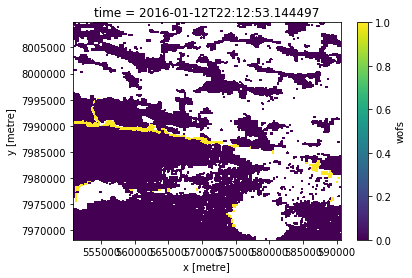

In [14]:
water_classes.isel(time = 1).wofs.plot();

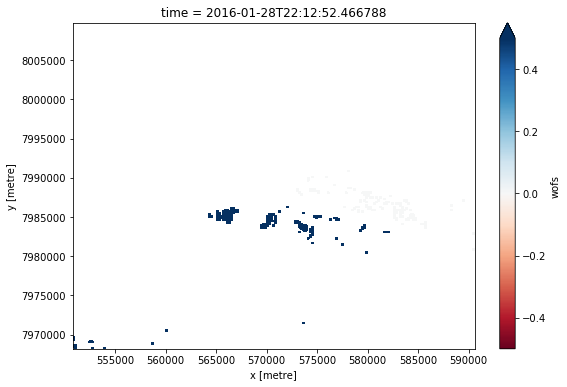

In [15]:
water_classes.isel(time=3).wofs.plot(cmap='RdBu', size=6, vmin=-0.5, vmax=0.5)

In [79]:
tide_data_2017 = pd.read_csv(tide_file_2017, parse_dates=['time'], index_col='time')
#tide_data_2018 = pd.read_csv(tide_file_2018, parse_dates=['time'], index_col='time')
tide_data_2016 = pd.read_csv(tide_file_2016, parse_dates= ['time'], index_col="time")
tide_data = pd.concat([tide_data_2016, tide_data_2017])
tide_data['tide_height'] = tide_data['tide']

,Fiji,Adjusted Residuals,Air Temperature,Barometric Pressure,Fiji,Lautoka,Residuals,Water Temperature,Wind Direction,Wind Gust,Wind Speed,tide,tide_height
time,,,,,,,,,,,,,
2016-12-31 23:00:00,NaN,-0.119,29.4,1006.3,NaN,NaN,-0.048,29.5,307,3.0,0.8,1.346,1.346
2016-12-31 22:00:00,NaN,-0.106,28.4,1006.1,NaN,NaN,-0.031,29.5,261,2.3,0.9,1.677,1.677
2016-12-31 21:00:00,NaN,-0.105,27.4,1005.6,NaN,NaN,-0.028,29.5,314,1.8,0.8,1.823,1.823
2016-12-31 20:00:00,NaN,-0.101,26.8,1005.5,NaN,NaN,-0.020,29.5,20,2.2,0.8,1.887,1.887
2016-12-31 19:00:00,NaN,-0.123,24.5,1005.1,NaN,NaN,-0.039,29.6,57,2.9,2.2,1.746,1.746


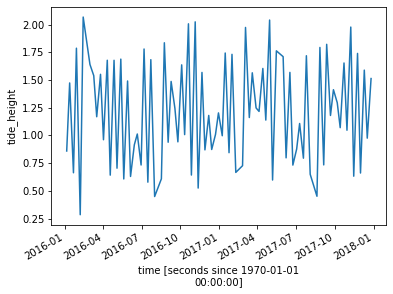

In [80]:
# First, we convert the data to an xarray dataset so we can analyse it in the same way as our Landsat data
tide_data_xr = tide_data.to_xarray()

# We want to convert our hourly tide heights to estimates of exactly how high the tide was at the time that
# each satellite image was taken. To do this, we can use `.interp` to 'interpolate' a tide height for each
# Landsat timestamp:

landsat_tideheights = tide_data_xr.interp(time=water_classes.time)

# We then want to put these values back into the Landsat dataset so that each image has an estimated tide height:
#landsat_ds['tide_height'] = landsat_tideheights.tide_height
water_classes['tide_height'] = landsat_tideheights.tide_height


# Plot the resulting tide heights for each Landsat image:
#landsat_ds.tide_height.plot()
water_classes.tide_height.plot()

plt.show()

In [1]:
#landsat_hightide = landsat_ds.where((landsat_ds.tide_height > tide_range[0]) & 
 #                                   (landsat_ds.tide_height < tide_range[1]), drop=True)
#landsat_hightide = landsat_ds.where((landsat_ds == 1), drop=True)
#landsat_hightide = landsat_ds.where(landsat_ds.water != 1)  
landsat_hightide = water_classes.where((water_classes.tide_height > tide_range[0]) & 
                                   (water_classes.tide_height < tide_range[1]), drop=True)
print(landsat_hightide)
#landsat_hightide.water.isel(time=3).plot(cmap='YlOrRd', size=6, vmin=-0.5, vmax=0.5)
landsat_hightide.wofs.isel(time=3).plot(cmap='YlOrRd', size=6, vmin=-0.5, vmax=0.5)

NameError: name 'water_classes' is not defined

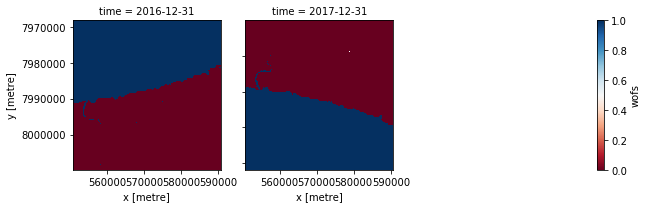

In [236]:
#landsat_resampled = landsat_hightide.water.compute().resample(time=time_step).min('time')
#landsat_resampled.plot(col='time', cmap='RdBu', col_wrap=3, vmin=-0.5, vmax=0.5)
landsat_resampled = landsat_hightide.wofs.compute().resample(time=time_step).max('time')

landsat_resampled.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

In [237]:
#landsat_resampled = xr.where(((landsat_resampled > 0.5)==1) & ((landsat_resampled <= 0.5)==0))
#landsat_hightide['water'] = (np.where((landsat_hightide.wofs <= 0.5)==1)&((landsat_hightide.wofs) > 0.5==0))
#landsat_resampled = np.where(landsat_resampled  1)
#landsat_resampled = xr.where(landsat_resampled < 0.5, landsat_resampled, 0*landsat_resampled)
#landsat_resampled = landsat_hightide.where(landsat_resampled < 0.5, landsat_resampled, 0*landsat_resampled).wofs.compute().resample(time=time_step).max('time')
for i in landsat_resampled.values:
    np.where(i < 0.5, i, 0*i)
    np.where(i >= 0.5, i, 0*i)
    
#landsat_resampled.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)
#for x in tuple:
#  if Landsat_resampled.time[x] <= 0.5:
#     x = 0

In [238]:
print(len(landsat_resampled.time))

2


Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
Exporting contour shapefile to output_waterlines2.shp


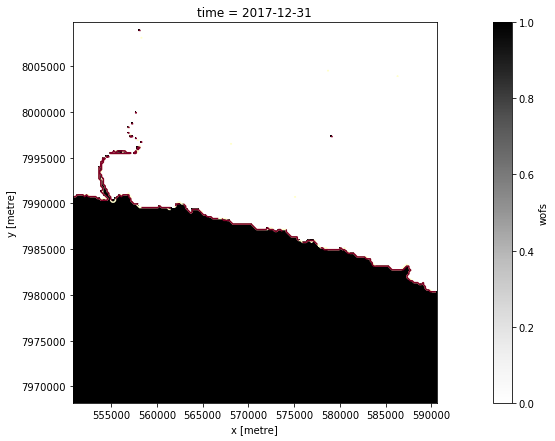

In [239]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in landsat_resampled.time.values]}
attribute_dtypes = {'time': 'str'}

# Extract waterline contours for the '0' water index threshold:
#contour_gdf = waterline_funcs.contour_extract(
#    z_values=[0],
#    ds_array=landsat_resampled,
#    ds_crs=landsat_ds.crs,
#    ds_affine=landsat_ds.geobox.transform,
#    output_shp=f'output_waterlines.shp',
#    attribute_data=attribute_data,
#    attribute_dtypes=attribute_dtypes,
#    min_vertices=50
#)

contour_gdf = waterline_funcs.contour_extract(
    z_values=[0.8],
    ds_array=landsat_resampled,
    ds_crs=scenes.crs,
    ds_affine=scenes.geobox.transform,
    output_shp=f'output_waterlines2.shp',
    attribute_data=attribute_data,
    attribute_dtypes=attribute_dtypes,
    min_vertices=5
)


# Plot output shapefile over the top of the first year's MNDWI layer
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
landsat_resampled.isel(time=-1).plot(ax=ax, cmap='Greys', alpha=1.0, edgecolors=None)
contour_gdf.plot(cmap='YlOrRd', ax=ax)


In [240]:
waterline_funcs.map_shapefile(gdf=contour_gdf)

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

In [234]:
client.restart()

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB
